In [1]:
import pandas as pd
from rich import print
import warnings
import xarray as xr
import numpy as np
import warnings
import matplotlib.pyplot as plt

warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 1000)

import pickle as pkl


In [2]:
energy_data = pd.read_csv("source\Energy_Data_20200920_20240118.csv")
dwd_solar = xr.open_dataset("source\dwd_icon_eu_TEST\dwd_icon_eu_pes10_20231027_20240108.nc")
dwd_solar_train = xr.open_dataset("source\dwd_icon_eu_TRAIN\dwd_icon_eu_pes10_20200920_20231027.nc")
dwd_solar.head()

<xarray.Dataset> Size: 2kB
Dimensions:                 (valid_time: 5, reference_time: 5, point: 5)
Coordinates:
  * valid_time              (valid_time) int64 40B 0 1 2 3 4
    latitude                (point) float64 40B ...
    longitude               (point) float64 40B ...
  * point                   (point) int64 40B 0 1 2 3 4
  * reference_time          (reference_time) datetime64[ns] 40B 2023-10-27 .....
Data variables:
    CloudCover              (reference_time, valid_time, point) float32 500B ...
    SolarDownwardRadiation  (reference_time, valid_time, point) float64 1kB ...
    Temperature             (reference_time, valid_time, point) float32 500B ...

In [53]:
solar_radiation = dwd_solar["SolarDownwardRadiation"].mean(dim="point").to_dataframe().reset_index()
temperature = dwd_solar["Temperature"].mean(dim="point").to_dataframe().reset_index()
cloud_cover = dwd_solar["CloudCover"].mean(dim="point").to_dataframe().reset_index()

dwd_solar_features = pd.merge(solar_radiation, temperature, on=["reference_time", "valid_time"])
dwd_solar_features = pd.merge(dwd_solar_features, cloud_cover, on=["reference_time", "valid_time"])
dwd_solar_features = dwd_solar_features[ dwd_solar_features["valid_time"] != 120 ]
dwd_solar_features["reference_time"] = dwd_solar_features["reference_time"].dt.tz_localize("UTC")
dwd_solar_features["added_time"] = dwd_solar_features["reference_time"] + pd.TimedeltaIndex(dwd_solar_features["valid_time"],unit="hours")
energy_data["dtm"] = pd.to_datetime(energy_data["dtm"])
modelling_table = dwd_solar_features
modelling_table = modelling_table.set_index("added_time").groupby("reference_time").resample("30T").interpolate("linear")
modelling_table = modelling_table.drop(columns="reference_time").reset_index()
modelling_table = modelling_table.merge(energy_data,how="inner",left_on="added_time",right_on="dtm")
modelling_table = modelling_table[modelling_table["added_time"] - modelling_table["reference_time"] < np.timedelta64(50,"h")]

modelling_table = modelling_table.drop(columns=['MIP', 'SS_Price', 'DA_Price', 'Wind_MW', 'boa_MWh', "reference_time", "valid_time"])
modelling_table = modelling_table.groupby(by="added_time").mean().reset_index()
modelling_table = modelling_table.sort_values(by="added_time")

# modelling_table.to_csv("energy_data\clean_solar_energy_test.csv")
modelling_table.head()

,added_time,SolarDownwardRadiation,Temperature,CloudCover,dtm,Solar_MW,Solar_capacity_mwp,Solar_installedcapacity_mwp
0,2023-10-27 00:00:00+00:00,0.0,8.954315,0.641780,2023-10-27 00:00:00+00:00,0.0,2453.150623,2609.200511
1,2023-10-27 00:30:00+00:00,0.0,8.843015,0.686105,2023-10-27 00:30:00+00:00,0.0,2453.150623,2609.200511
2,2023-10-27 01:00:00+00:00,0.0,8.731714,0.730430,2023-10-27 01:00:00+00:00,0.0,2453.150623,2609.200511
3,2023-10-27 01:30:00+00:00,0.0,8.593836,0.787374,2023-10-27 01:30:00+00:00,0.0,2453.150623,2609.200511
4,2023-10-27 02:00:00+00:00,0.0,8.455957,0.844317,2023-10-27 02:00:00+00:00,0.0,2453.150623,2609.200511


In [58]:
solar_radiation = dwd_solar_train["SolarDownwardRadiation"].mean(dim="point").to_dataframe().reset_index()
temperature = dwd_solar_train["Temperature"].mean(dim="point").to_dataframe().reset_index()
cloud_cover = dwd_solar_train["CloudCover"].mean(dim="point").to_dataframe().reset_index()

dwd_solar_train_features = pd.merge(solar_radiation, temperature, on=["ref_datetime", "valid_datetime"])
dwd_solar_train_features = pd.merge(dwd_solar_train_features, cloud_cover, on=["ref_datetime", "valid_datetime"])
dwd_solar_train_features = dwd_solar_train_features[ dwd_solar_train_features["valid_datetime"] != 120 ]
dwd_solar_train_features["ref_datetime"] = dwd_solar_train_features["ref_datetime"].dt.tz_localize("UTC")
dwd_solar_train_features["added_time"] = dwd_solar_train_features["ref_datetime"] + pd.TimedeltaIndex(dwd_solar_train_features["valid_datetime"],unit="hours")
energy_data["dtm"] = pd.to_datetime(energy_data["dtm"])
modelling_table = dwd_solar_train_features
modelling_table = modelling_table.set_index("added_time").groupby("ref_datetime").resample("30T").interpolate("linear")
modelling_table = modelling_table.drop(columns="ref_datetime").reset_index()
modelling_table = modelling_table.merge(energy_data,how="inner",left_on="added_time",right_on="dtm")
modelling_table = modelling_table[modelling_table["added_time"] - modelling_table["ref_datetime"] < np.timedelta64(50,"h")]

modelling_table = modelling_table.drop(columns=['MIP', 'SS_Price', 'DA_Price', 'Wind_MW', 'boa_MWh', "ref_datetime", "valid_datetime"])
modelling_table = modelling_table.groupby(by="added_time").mean().reset_index()
# MISSING DATA PROCESS
missing_values = modelling_table[modelling_table.isna().any(axis=1)]
modelling_table["time"] = modelling_table["added_time"].dt.time
mean_values_by_time = modelling_table.groupby(by="time").mean()["Solar_MW"]
print("Before mean by group fill\n", modelling_table.isna().sum())
for i in missing_values.index:
    modelling_table["Solar_MW"].iloc[i] = mean_values_by_time[ modelling_table["time"][i] ]
print("After mean by group fill\n", modelling_table.isna().sum())
modelling_table.to_csv("energy_data\clean_solar_energy_train.csv")
modelling_table.head()

Before mean by group fill
 added_time                      0
SolarDownwardRadiation          0
Temperature                     0
CloudCover                      0
dtm                             0
Solar_MW                       66
Solar_capacity_mwp              0
Solar_installedcapacity_mwp     0
time                            0
dtype: int64

C:\Users\Franc\AppData\Local\Temp/ipykernel_13024/2939612821.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  modelling_table["Solar_MW"].iloc[i] = mean_values_by_time[ modelling_table["time"][i] ]


After mean by group fill
 added_time                     0
SolarDownwardRadiation         0
Temperature                    0
CloudCover                     0
dtm                            0
Solar_MW                       0
Solar_capacity_mwp             0
Solar_installedcapacity_mwp    0
time                           0
dtype: int64

,added_time,SolarDownwardRadiation,Temperature,CloudCover,dtm,Solar_MW,Solar_capacity_mwp,Solar_installedcapacity_mwp,time
0,2020-09-20 00:00:00+00:00,0.0,13.646173,0.450405,2020-09-20 00:00:00+00:00,0.0,2130.537493,2228.208777,00:00:00
1,2020-09-20 00:30:00+00:00,0.0,13.658508,0.472211,2020-09-20 00:30:00+00:00,0.0,2130.537493,2228.208777,00:30:00
2,2020-09-20 01:00:00+00:00,0.0,13.670843,0.494018,2020-09-20 01:00:00+00:00,0.0,2130.537493,2228.208777,01:00:00
3,2020-09-20 01:30:00+00:00,0.0,13.732101,0.520214,2020-09-20 01:30:00+00:00,0.0,2130.537493,2228.208777,01:30:00
4,2020-09-20 02:00:00+00:00,0.0,13.793360,0.546410,2020-09-20 02:00:00+00:00,0.0,2130.537493,2228.208777,02:00:00


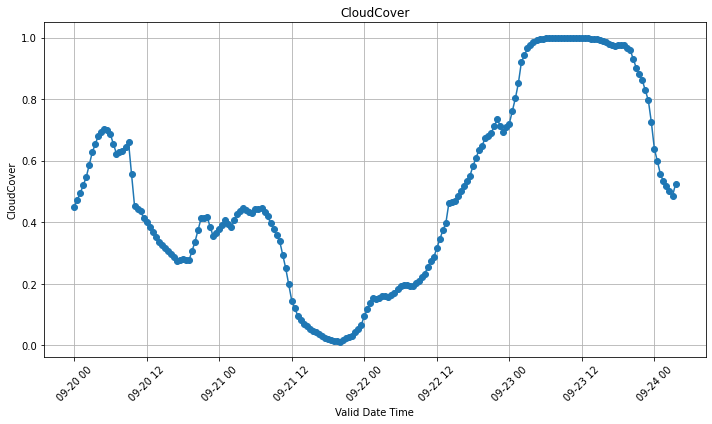

In [56]:
# Convertir les colonnes en numpy array
x = modelling_table["added_time"][:200].to_numpy()
y = modelling_table["CloudCover"][:200].to_numpy()

# Créer le tracé
plt.figure(figsize=(10, 6))
plt.plot(x, y, marker='o', linestyle='-')
plt.title('CloudCover')
plt.xlabel('Valid Date Time')
plt.ylabel('CloudCover')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# Afficher le tracé
plt.show()

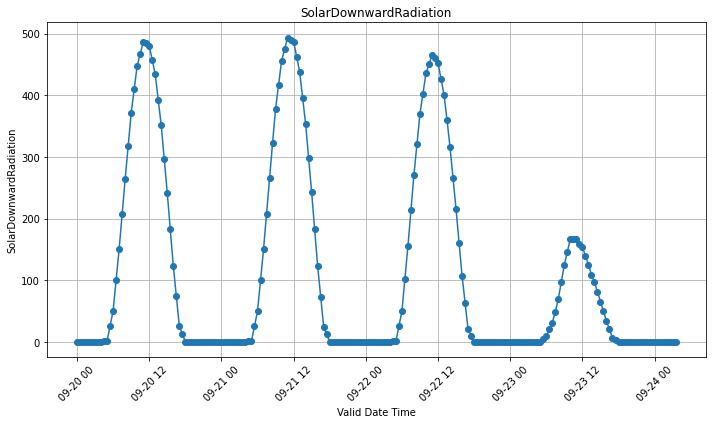

In [57]:
# Convertir les colonnes en numpy array
x = modelling_table["added_time"][:200].to_numpy()
y = modelling_table["SolarDownwardRadiation"][:200].to_numpy()

# Créer le tracé
plt.figure(figsize=(10, 6))
plt.plot(x, y, marker='o', linestyle='-')
plt.title('SolarDownwardRadiation')
plt.xlabel('Valid Date Time')
plt.ylabel('SolarDownwardRadiation')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# Afficher le tracé
plt.show()

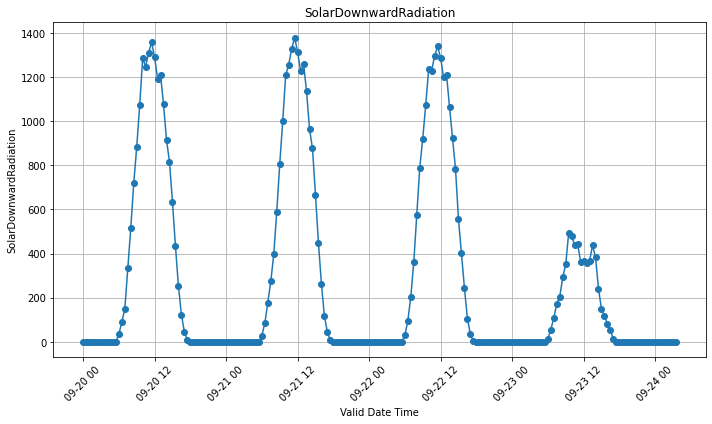

In [10]:
# Convertir les colonnes en numpy array
x = modelling_table["added_time"][:200].to_numpy()
y = modelling_table["Solar_MW"][:200].to_numpy()

# Créer le tracé
plt.figure(figsize=(10, 6))
plt.plot(x, y, marker='o', linestyle='-')
plt.title('SolarDownwardRadiation')
plt.xlabel('Valid Date Time')
plt.ylabel('SolarDownwardRadiation')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# Afficher le tracé
plt.show()